In [1]:
import sys
print(sys.prefix)  # Menampilkan path environment aktif

c:\Jatmiar Folder\python-project\Prediksi Konsumsi Energi Listrik\.venv


In [2]:
#!pip install pandas

In [3]:
#!pip install matplotlib seaborn

In [4]:
#!pip install tensorflow scikit-learn

Library that is Used

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [7]:
df = pd.read_csv("C:\Jatmiar Folder\python-project\Prediksi Konsumsi Energi Listrik\Dataset(1).csv", sep=";")
df.head()

,no,tanggal,konsumsi(kwh)
0,1,30/01/2018,23543455
1,2,28/02/2018,21698806
2,3,30/03/2018,24374770
3,4,30/04/2018,24071263
4,5,30/05/2018,25530256


In [8]:
df.dtypes

no                int64
tanggal          object
konsumsi(kwh)     int64
dtype: object

In [9]:
df.tanggal = pd.to_datetime(df.tanggal)

Explorasi Data Analystics

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   no             63 non-null     int64         
 1   tanggal        63 non-null     datetime64[ns]
 2   konsumsi(kwh)  63 non-null     int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.6 KB


In [11]:
df.shape

(63, 3)

In [12]:
# Mengecek data kosong
df.isnull().sum()
# Mengecek data duplikat
df.duplicated().sum()

np.int64(0)

In [13]:
# Menampilkan deskripsi data
display(df["konsumsi(kwh)"].describe())

count    6.300000e+01
mean     2.883702e+07
std      3.251333e+06
min      2.169881e+07
25%      2.568833e+07
50%      2.978734e+07
75%      3.125809e+07
max      3.583545e+07
Name: konsumsi(kwh), dtype: float64

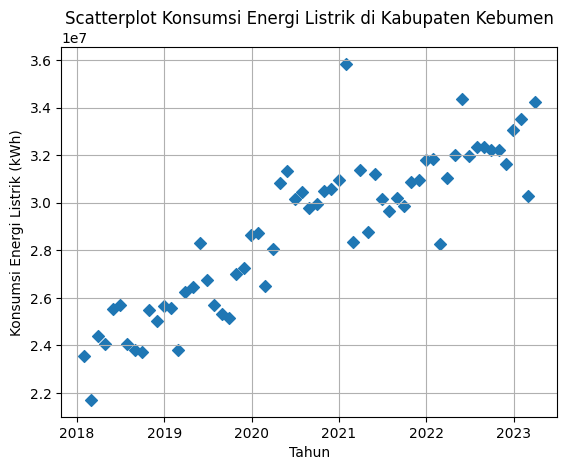

In [14]:
# Membuat Scatterplot
plt.Figure(figsize=(18,10))

plt.scatter(x=df["tanggal"], y=df["konsumsi(kwh)"], marker="D")
plt.grid(True)
plt.title("Scatterplot Konsumsi Energi Listrik di Kabupaten Kebumen")
plt.xlabel("Tahun")
plt.ylabel("Konsumsi Energi Listrik (kWh)")
plt.show()

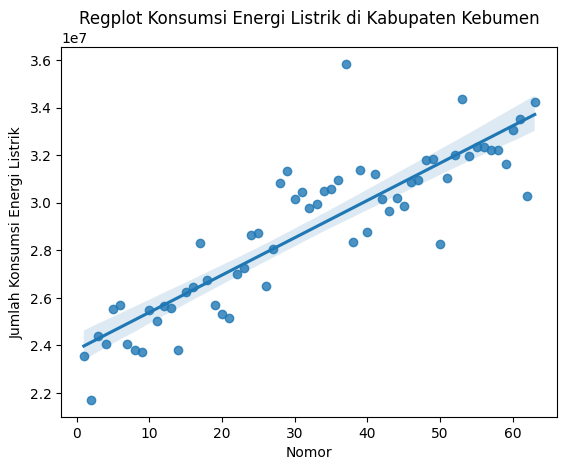

In [15]:
# Membuat regplot
sns.regplot(data=df, x="no", y="konsumsi(kwh)")
plt.title("Regplot Konsumsi Energi Listrik di Kabupaten Kebumen")
plt.xlabel("Nomor")
plt.ylabel("Jumlah Konsumsi Energi Listrik")
plt.show()

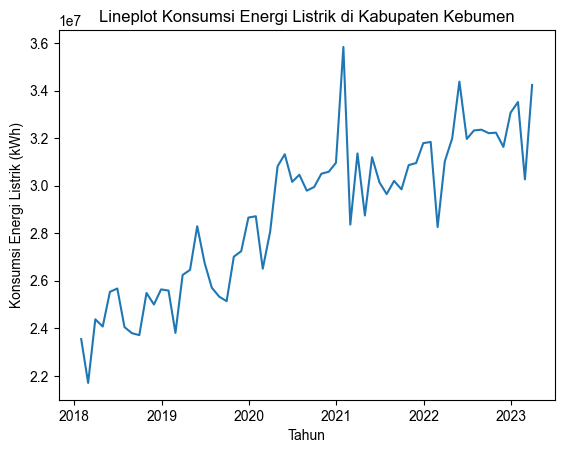

In [16]:
# Membuat Lineplot
plt.Figure(figsize=(16,8))
ax = sns.lineplot(data=df,
             x=df["tanggal"],
             y=df["konsumsi(kwh)"],
             markers="o",
             dashes=True)
sns.set_style("whitegrid")
ax.set_title("Lineplot Konsumsi Energi Listrik di Kabupaten Kebumen")
ax.set(xlabel="Tahun", ylabel="Konsumsi Energi Listrik (kWh)")
plt.show()

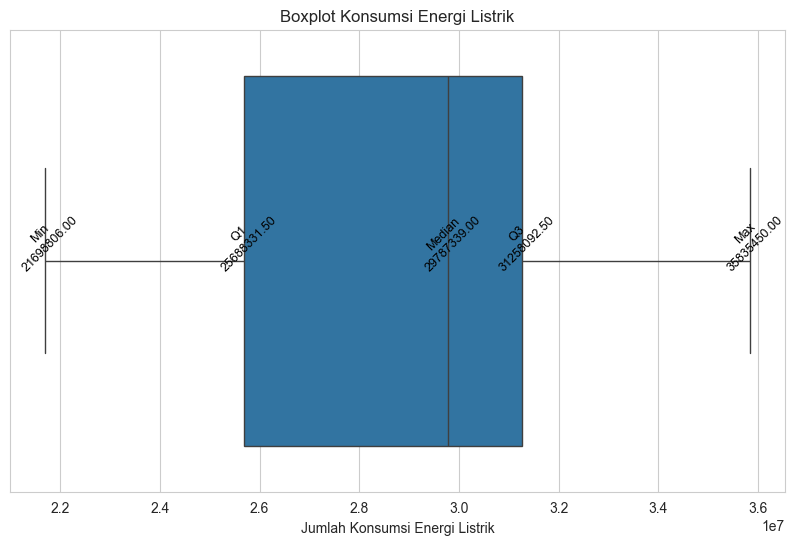

In [17]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(x=df["konsumsi(kwh)"])
plt.title("Boxplot Konsumsi Energi Listrik")

# Menambahkan nilai-nilai statistik pada plot
desc = df["konsumsi(kwh)"].describe()
stat_labels = ['Min', 'Q1', 'Median', 'Q3', 'Max']
stat_values = [desc['min'], desc['25%'], desc['50%'], desc['75%'], desc['max']]

for val, label in zip(stat_values, stat_labels):
    plt.text(val, 0.02, f'{label}\n{val:.2f}', ha='center', color='black', fontsize=9, rotation=45)

plt.xlabel("Jumlah Konsumsi Energi Listrik")
plt.show()


Data Preparation

In [18]:
df1 = df.drop("no", axis=1)
#df1 = df.copy()
df1.head()

,tanggal,konsumsi(kwh)
0,2018-01-30,23543455
1,2018-02-28,21698806
2,2018-03-30,24374770
3,2018-04-30,24071263
4,2018-05-30,25530256


In [19]:
df1.set_index("tanggal", inplace=True)
df1.index

DatetimeIndex(['2018-01-30', '2018-02-28', '2018-03-30', '2018-04-30',
               '2018-05-30', '2018-06-30', '2018-07-30', '2018-08-30',
               '2018-09-30', '2018-10-30', '2018-11-30', '2018-12-30',
               '2019-01-30', '2019-02-28', '2019-03-30', '2019-04-30',
               '2019-05-30', '2019-06-30', '2019-07-30', '2019-08-30',
               '2019-09-30', '2019-10-30', '2019-11-30', '2019-12-30',
               '2020-01-30', '2020-02-28', '2020-03-30', '2020-04-30',
               '2020-05-30', '2020-06-30', '2020-07-30', '2020-08-30',
               '2020-09-30', '2020-10-30', '2020-11-30', '2020-12-30',
               '2021-01-30', '2021-02-28', '2021-03-30', '2021-04-30',
               '2021-05-30', '2021-06-30', '2021-07-30', '2021-08-30',
               '2021-09-30', '2021-10-30', '2021-11-30', '2021-12-30',
               '2022-01-30', '2022-02-28', '2022-03-30', '2022-04-30',
               '2022-05-30', '2022-06-30', '2022-07-30', '2022-08-30',
      

In [20]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps   #find the end of this pattern
        if end_ix > (len(sequence)-1):
            break  #gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [21]:
df2 = df1.values.reshape(-1,1)

In [22]:
scaler = MinMaxScaler(feature_range=(0,1))
df_scaler = scaler.fit_transform(df2)
df_scaler

array([[0.13048705],
       [0.        ],
       [0.18929273],
       [0.16782321],
       [0.27102967],
       [0.28103297],
       [0.16611262],
       [0.14801858],
       [0.14230832],
       [0.26774007],
       [0.23340228],
       [0.27833862],
       [0.27490153],
       [0.14885754],
       [0.32120643],
       [0.33647215],
       [0.46636451],
       [0.35706763],
       [0.28339032],
       [0.25666587],
       [0.24329629],
       [0.37558398],
       [0.39208337],
       [0.49208285],
       [0.49605939],
       [0.33986263],
       [0.45065986],
       [0.64466977],
       [0.68061981],
       [0.59833812],
       [0.61950616],
       [0.57216784],
       [0.58315644],
       [0.62255547],
       [0.62858851],
       [0.65515613],
       [1.        ],
       [0.47113721],
       [0.68305413],
       [0.49830101],
       [0.67179261],
       [0.59673456],
       [0.56203856],
       [0.60118123],
       [0.57608065],
       [0.64818015],
       [0.65439831],
       [0.713

In [23]:
scaler_1d = np.array(df_scaler).flatten()
np.shape(scaler_1d)

(63,)

In [24]:
n_steps = 3
X, y = split_sequence(scaler_1d, n_steps)

for i in range(len(X)):
    print(X[i], y[i])

[0.13048705 0.         0.18929273] 0.16782321178916293
[0.         0.18929273 0.16782321] 0.27102967295491065
[0.18929273 0.16782321 0.27102967] 0.28103296652303045
[0.16782321 0.27102967 0.28103297] 0.16611262192073317
[0.27102967 0.28103297 0.16611262] 0.14801858206233387
[0.28103297 0.16611262 0.14801858] 0.14230831589166426
[0.16611262 0.14801858 0.14230832] 0.2677400661712921
[0.14801858 0.14230832 0.26774007] 0.23340228416305875
[0.14230832 0.26774007 0.23340228] 0.27833862124560826
[0.26774007 0.23340228 0.27833862] 0.274901525425695
[0.23340228 0.27833862 0.27490153] 0.14885753648461408
[0.27833862 0.27490153 0.14885754] 0.321206433436394
[0.27490153 0.14885754 0.32120643] 0.33647214996713504
[0.14885754 0.32120643 0.33647215] 0.46636450631422854
[0.32120643 0.33647215 0.46636451] 0.3570676321763495
[0.33647215 0.46636451 0.35706763] 0.2833903152686026
[0.46636451 0.35706763 0.28339032] 0.25666586779719425
[0.35706763 0.28339032 0.25666587] 0.24329628729421215
[0.28339032 0.256

In [25]:
train_split = 0.8
data_size = len(X)
train_size = int(train_split*data_size)
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

print("Train data size: ", X_train.shape, y_train.shape)
print("Test data size: ", X_test.shape, y_test.shape)


Train data size:  (48, 3) (48,)
Test data size:  (12, 3) (12,)


In [26]:
n_features = 1
X_train_model = X_train.reshape(X_train.shape[0], X_train.shape[1], n_features)
X_test_model = X_test.reshape(X_test.shape[0], X_test.shape[1], n_features)

print(X_train_model.shape, X_test_model.shape)

(48, 3, 1) (12, 3, 1)


Membangun LSTM Model

In [27]:
# Membuat model
model_basic = Sequential()
model_basic.add(LSTM(20, input_shape=(n_steps, n_features)))
model_basic.add(Dense(1))
model_basic.compile(optimizer="Adam",
                    loss="mean_squared_error")
model_basic.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20)             │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,781 (6.96 KB)

 Trainable params: 1,781 (6.96 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Training model
history = model_basic.fit(X_train_model, 
                          y_train,
                          validation_data=(X_test_model, y_test),
                          epochs=100,
                          batch_size=16)
history

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 391ms/step - loss: 0.2489 - val_loss: 0.5666
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.2505 - val_loss: 0.5232
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.2069 - val_loss: 0.4824
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.1812 - val_loss: 0.4435
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.1874 - val_loss: 0.4063
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.1517 - val_loss: 0.3709
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.1492 - val_loss: 0.3369
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.1246 - val_loss: 0.3046
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.1165 - val_loss: 0.2736
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.1128 - val_loss: 0.2440
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0784 - val_loss: 0.2165
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0648 - val_l

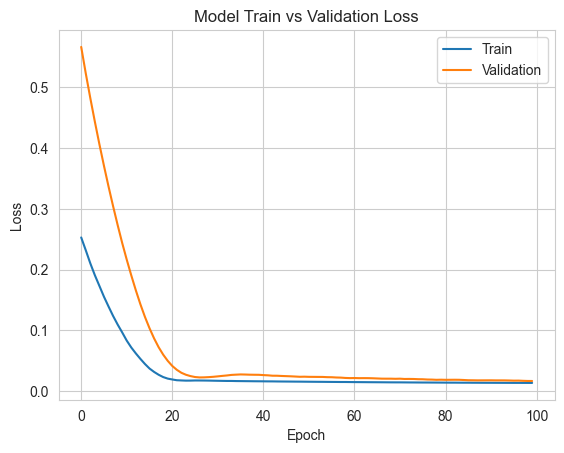

In [30]:
# Visualisasi train and validation loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Train vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"], loc="upper right")
plt.show()

In [32]:
# Membuat prediksi berdasarkan data uji
y_pred_scaler = model_basic.predict(X_test_model)
y_pred = scaler.inverse_transform(y_pred_scaler)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1))
print(y_pred)
print(y_test_actual)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
[[30076418.]
 [29945666.]
 [31480298.]
 [31966068.]
 [32102828.]
 [31472098.]
 [31561032.]
 [31534596.]
 [31380304.]
 [31499684.]
 [31797018.]
 [31728938.]]
[[31990770.]
 [34375823.]
 [31963897.]
 [32321325.]
 [32353280.]
 [32205685.]
 [32227659.]
 [31628831.]
 [33068660.]
 [33518691.]
 [30260397.]
 [34238166.]]
